In [1]:
import cv2
import numpy as np
import  matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def getImg(cls,i):
    return cv2.imread("{}/{}{}.pgm".format("D:/objRecognition/CarData/TrainImages", cls, i+1), 0)


def resize(img, scaleFactor):
    return cv2.resize(img, (int(img.shape[1] * (1 / scaleFactor)), int(img.shape[0] * (1 / scaleFactor))), 
                      interpolation=cv2.INTER_AREA)


def get_pyramid(image, scaleFactor=1.5, minSize=(200, 80)):
    yield image
    if type(scaleFactor) != float:
        raise TypeError, 'scaleFactor only accepted float'
    while True:
        image = resize(image, scaleFactor)
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        yield image
    
    
def sliding_window(image, stepSize, windowSize):
    for y in xrange(0, image.shape[0], stepSize):
        for x in xrange(0, image.shape[1], stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

            
def area(box):
    return (abs(box[2] - box[0])) * (abs(box[3] - box[1]))


def overlaps(a, b, thresh):
    x1 = np.maximum(a[0], b[0])
    x2 = np.minimum(a[2], b[2])
    y1 = np.maximum(a[1], b[1])
    y2 = np.minimum(a[3], b[3])
    intersect = float(area([x1, y1, x2, y2]))
    return intersect / np.minimum(area(a), area(b)) >= thresh


def is_inside(rec1, rec2):
    def inside(a,b):
        if (a[0] >= b[0]) and (a[2] <= b[0]):
            return (a[1] >= b[1]) and (a[3] <= b[3])
        else:
            return False
    return (inside(rec1, rec2) or inside(rec2, rec1))


def non_max_suppression(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    pick = []
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    return boxes[pick].astype("float")


def car_detector():
    POS = 'pos-'
    NEG = 'neg-'
    
    detector = cv2.SIFT()
    extractor = cv2.DescriptorExtractor_create('SIFT')

    K = 12
    bow_kmeans_trainer = cv2.BOWKMeansTrainer(K)

    FLANN_INDEX_KDTREE = 1
    flann_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    matcher = cv2.FlannBasedMatcher(flann_params, search_params)
    bow_extractor = cv2.BOWImgDescriptorExtractor(extractor, matcher)
    
    SAMPLES_NUM = 10
    for i in xrange(0, SAMPLES_NUM):
        pos_img = getImg(POS, i)
        pos_keypoints = detector.detect(pos_img)
        extracted_pos_keypoints, extracted_pos_descriptors = extractor.compute(pos_img, pos_keypoints)
        if extracted_pos_descriptors is not None:
            bow_kmeans_trainer.add(extracted_pos_descriptors)

    vocabulary = bow_kmeans_trainer.cluster()
    bow_extractor.setVocabulary(vocabulary)

    traindata, trainlabels = [],[]
    for i in xrange(0, 400):
        pos_img = getImg(POS, i)
        pos_keypoints = detector.detect(pos_img)
        extracted_pos_keypoints, extracted_pos_descriptors = extractor.compute(pos_img, pos_keypoints)
        bow_pos_keypoints = bow_extractor.compute(pos_img, extracted_pos_keypoints)
        if bow_pos_keypoints is not None:
            traindata.extend(bow_pos_keypoints)
            trainlabels.append(1)

        neg_img = getImg(NEG, i)
        neg_keypoints = detector.detect(neg_img)
        extracted_neg_keypoints, extracted_neg_descriptors = extractor.compute(neg_img, neg_keypoints)
        bow_neg_keypoints = bow_extractor.compute(neg_img, extracted_neg_keypoints)
        if bow_neg_keypoints is not None:
            traindata.extend(bow_neg_keypoints)
            trainlabels.append(-1)

    #svm_param = dict(svm_type=cv2.SVM_C_SVC, kernel_type=cv2.SVM_RBF, gamma=1.0, Cvalue=35)
    svm_param = dict(svm_type=cv2.SVM_C_SVC, kernel_type=cv2.SVM_LINEAR, gamma=0.1, Cvalue=30)
    SVM = cv2.SVM()
    SVM.train(np.array(traindata), np.array(trainlabels), params=svm_param)
    return SVM, bow_extractor


def in_range(number, test, thresh=0.2):
    return abs(number - test) < thresh

In [3]:
def main(file_path):
    font = cv2.FONT_HERSHEY_PLAIN
    svm, bow_extractor = car_detector()
    #svm = cv2.SVM()
    #svm.load('D:/objRecognition/car_model')
    detector = cv2.SIFT()

    w, h = 100, 40
    img = cv2.imread(file_path)
    print 'shape', img.shape
    
    rectangles = []
    scaleFactor = 1.25
    scale = 1

    for resized in get_pyramid(img, scaleFactor):  
        scale = float(img.shape[1]) / float(resized.shape[1])
        for (x, y, roi) in sliding_window(resized, 20, (w, h)):

            if roi.shape[1] != w or roi.shape[0] != h:
                continue

            try:
                keypoints = detector.detect(roi)
                extracted_keypoints = bow_extractor.compute(roi, keypoints)
                result = svm.predict(extracted_keypoints, returnDFVal=True)

                if result < -1.0:
                    rx, ry, rx2, ry2 = int(x * scale), int(y * scale), int((x+w) * scale), int((y+h) * scale)
                    rectangles.append([rx, ry, rx2, ry2, abs(result)])
            except Exception as e:
                pass

    windows = np.array(rectangles)
    boxes = non_max_suppression(windows, overlapThresh=0.05)

    for (x, y, x2, y2, result) in boxes:
        cv2.rectangle(img, (int(x),int(y)),(int(x2), int(y2)),(0, 255, 0), 1)
        cv2.putText(img, "%f" % result, (int(x),int(y)), font, 1, (0, 255, 0))

    plt.imshow(img)
    plt.show()
    
    #svm.save('D:/objRecognition/car_model')
    #cv2.imwrite('D:/objRecognition/output/car_deteced_05.jpg', img)

shape (216L, 314L, 3L)


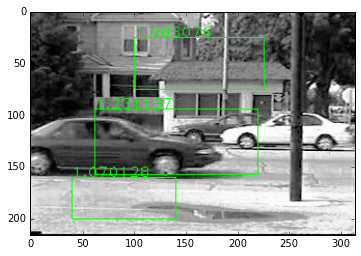

In [5]:
if __name__=='__main__':
    file_path = 'D:/objRecognition/CarData/TestImages_Scale/test-102.pgm'
    main(file_path)